##  Import Libraries and Load Cleaned Data

In [1]:
import pandas as pd
import numpy as np
import re

# Load cleaned dataset
df = pd.read_csv("../Datasets/Clean_Food_Inspections.csv")

# Quick preview
df.head()


,Unnamed: 0,Inspection ID,DBA Name,AKA Name,License Number,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,IsPass
0,0,1170324,CAPTAIN HOOKS FISH & CHICKEN/FIREHOUSE GRILL,CAPTAIN HOOKS FISH & CHICKEN FIREHOUSE GRILL,1804138.0,Restaurant,3,5648 W ROOSEVELT,Chicago,IL,60644.0,2012-06-18,Complaint,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,41.865679,-87.766331,"(41.86567851033532, -87.76633113301574)",True
1,1,2614750,CHICK-FIL-A PULLMAN,CHICK-FIL-A PULLMAN,3015728.0,Restaurant,3,11131 S CORLISS AVE,Chicago,IL,60628.0,2025-03-31,License,Pass,58. ALLERGEN TRAINING AS REQUIRED - Comments: ...,41.691956,-87.600558,"(41.69195600663339, -87.60055824712973)",True
2,2,2609909,HAPPY MARKET,HAPPY MARKET,2912802.0,Grocery Store,2,2334 S WENTWORTH AVE,Chicago,IL,60616.0,2025-01-02,Canvass,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.849954,-87.632094,"(41.84995400192252, -87.63209419559098)",True
3,3,2609927,SAT KAIVAL FOOD INC/SUBWAY,SAT KAIVAL FOOD INC/SUBWAY,2728400.0,Restaurant,3,1916 S STATE ST,Chicago,IL,60616.0,2025-01-02,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.856053,-87.627311,"(41.85605269621059, -87.62731125804903)",True
4,4,2608378,Babas Halal,Babas Halal,2684170.0,Restaurant,3,7901 S DAMEN AVE,Chicago,IL,60620.0,2024-12-03,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.750189,-87.672986,"(41.750189342293375, -87.67298583977204)",False


## Create violations 

In [2]:
# Making the violation count
df['violation_count'] = df['Violations'].fillna('').apply(
    lambda x: len(re.findall(r'\d+\.', x))
)
#Looks for key red flag terms in violation 
critical_keywords = ['serious', 'critical', 'food borne', 'illness', 'vomit']

def has_critical_violation(text):
    if pd.isnull(text):
        return 0
    return int(any(keyword in text.lower() for keyword in critical_keywords))

df['critical_violation_flag'] = df['Violations'].apply(has_critical_violation)

# first violation code to see if there are common first offenses
df['first_violation_code'] = df['Violations'].str.extract(r'^(\d+)\.', expand=False)

# Save to the Datasets folder
df.to_csv("../Datasets/Feature_with_violation.csv", index=False)


## Feature Engineering
Date-based features

In [3]:
# use inspection data to extract time based patterns
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])

df['inspection_year'] = df['Inspection Date'].dt.year
df['inspection_month'] = df['Inspection Date'].dt.month
df['inspection_dayofweek'] = df['Inspection Date'].dt.dayofweek
df['inspection_quarter'] = df['Inspection Date'].dt.quarter
df['is_weekend'] = df['inspection_dayofweek'].apply(lambda x: x >= 5)



Business level features

In [4]:
#Aggregate by License Number to learn about business behavior.

# Number of inspections per business
df['inspections_per_business'] = df.groupby('License Number')['Inspection ID'].transform('count')

# Fail rate history per business 
fail_rate = df.groupby('License Number')['IsPass'].apply(lambda x: 1 - x.mean()).rename("fail_rate_per_business")
df = df.merge(fail_rate, on='License Number', how='left')


Violation Severity Score (Weighted Keyword Count)

In [5]:
# Give the model a signal on how bad the violations were
def violation_score(text):
    if pd.isnull(text):
        return 0
    text = text.lower()
    score = 0
    score += 3 * text.count('critical')
    score += 2 * text.count('serious')
    score += 1 * text.count('violation')
    return score

df['violation_score'] = df['Violations'].apply(violation_score)


Violation count placed in bins of low medium or high

In [6]:
def bin_violations(count):
    if count == 0:
        return 'None'
    elif count <= 2:
        return 'Low'
    elif count <= 5:
        return 'Medium'
    else:
        return 'High'

df['violation_level'] = df['violation_count'].apply(bin_violations)
df = pd.get_dummies(df, columns=['violation_level'], drop_first=True)


Geographic grouping from Zip and Coordinates

In [7]:
df['zip_prefix'] = df['Zip'].astype(str).str[:3]


Interactions capture effects like high-risk plus the combination of lots of violations

In [8]:
df['risk_x_violations'] = df['Risk'].astype(float) * df['violation_count']


Flag First-Time Inspections (by License Number + Date)

In [9]:
df['first_inspection'] = df.sort_values('Inspection Date').groupby('License Number')['Inspection Date'].transform('min')
df['is_first_inspection'] = (df['Inspection Date'] == df['first_inspection']).astype(int)


One-hot encoding the 6 relevant cateforical columns

In [10]:
# Fill missing values
for col in ['Facility Type', 'City', 'State', 'Risk', 'Zip', 'Results', 'first_violation_code']:
    df[col] = df[col].fillna('Unknown')

# Reduce cardinality of City and Zip keep top 15, use other
top_cities = df['City'].value_counts().nlargest(15).index
df['City'] = df['City'].apply(lambda x: x if x in top_cities else 'Other')

top_zips = df['Zip'].astype(str).value_counts().nlargest(15).index
df['Zip'] = df['Zip'].astype(str).apply(lambda x: x if x in top_zips else 'Other')

# Encode all 7 columns
cols_to_encode = ['Facility Type', 'City', 'State', 'Risk', 'Zip', 'first_violation_code']
df_encoded = pd.get_dummies(df, columns=cols_to_encode, prefix=cols_to_encode, drop_first=True)

# Confirm encoding
encoded_columns = [col for col in df_encoded.columns if any(prefix in col for prefix in cols_to_encode)]
print(f" One-hot encoding complete. {len(encoded_columns)} new columns created.")
print("Sample encoded columns:", encoded_columns[:10])

# Save to dataset
df_encoded.to_csv("../Datasets/Encoded_Food_Inspections.csv", index=False)




 One-hot encoding complete. 132 new columns created.
Sample encoded columns: ['Facility Type_Bakery', 'Facility Type_Cafe', 'Facility Type_Cafeteria', 'Facility Type_Catering', 'Facility Type_Children Services Facility', 'Facility Type_Church', 'Facility Type_Convenience Store', 'Facility Type_Culinary School', 'Facility Type_Daycare', 'Facility Type_Gas Station']


In [11]:
# Fill missing values for only pre-inspection columns
pre_inspection_cols = ['Facility Type', 'City', 'State', 'Risk', 'Zip']

for col in pre_inspection_cols:
    df[col] = df[col].fillna('Unknown')

# Reduce cardinality of City and Zip keep top 15, the rest other
top_cities = df['City'].value_counts().nlargest(15).index
df['City'] = df['City'].apply(lambda x: x if x in top_cities else 'Other')

top_zips = df['Zip'].astype(str).value_counts().nlargest(15).index
df['Zip'] = df['Zip'].astype(str).apply(lambda x: x if x in top_zips else 'Other')
df['Zip'] = df['Zip'].astype(str)

# Encode only safe, pre-inspection features
safe_to_encode = ['Facility Type', 'City', 'State', 'Risk', 'Zip']
df_encoded = pd.get_dummies(df, columns=safe_to_encode, prefix=safe_to_encode, drop_first=True)

# Confirm encoding
encoded_columns = [col for col in df_encoded.columns if any(prefix in col for prefix in safe_to_encode)]
print(f"One-hot encoding complete. {len(encoded_columns)} new columns created.")
print("Sample encoded columns:", encoded_columns[:10])

# Save for modeling
df_encoded.to_csv("../Datasets/Encoded_PreInspectionOnly.csv", index=False)


One-hot encoding complete. 65 new columns created.
Sample encoded columns: ['Facility Type_Bakery', 'Facility Type_Cafe', 'Facility Type_Cafeteria', 'Facility Type_Catering', 'Facility Type_Children Services Facility', 'Facility Type_Church', 'Facility Type_Convenience Store', 'Facility Type_Culinary School', 'Facility Type_Daycare', 'Facility Type_Gas Station']


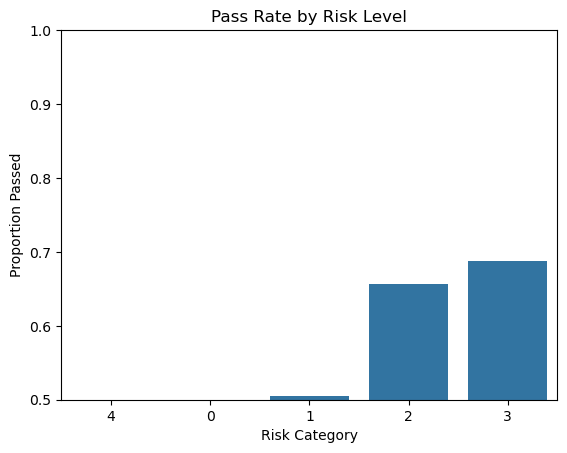

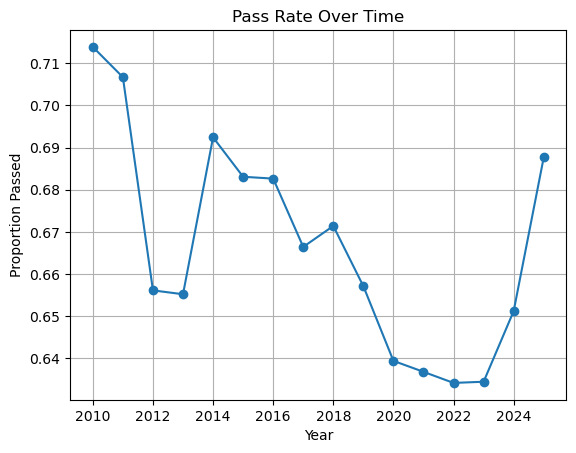

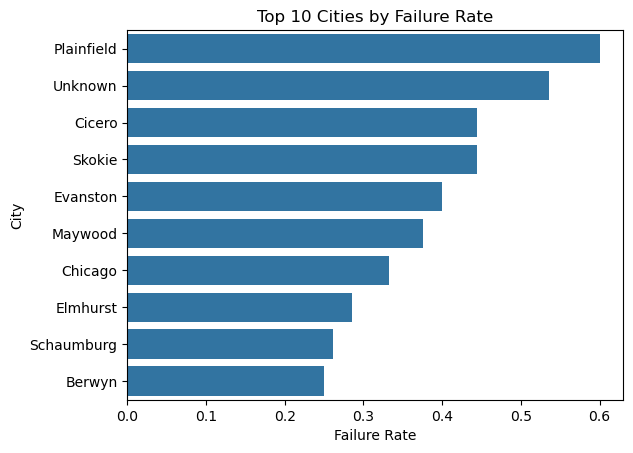

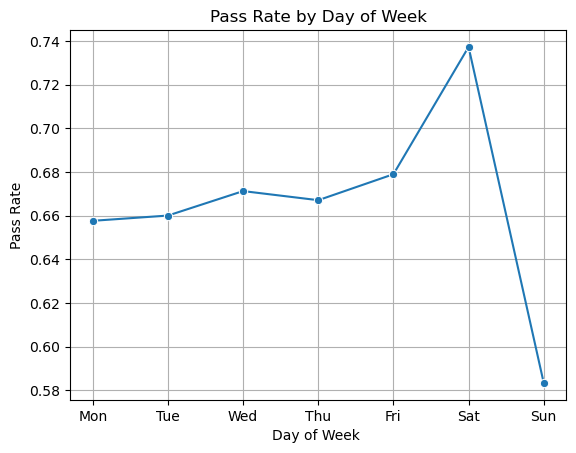

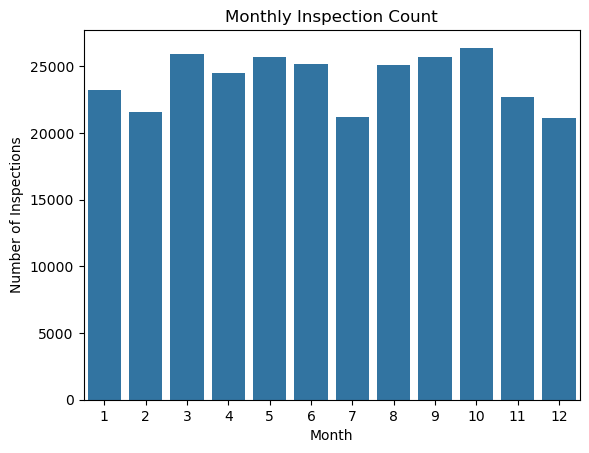

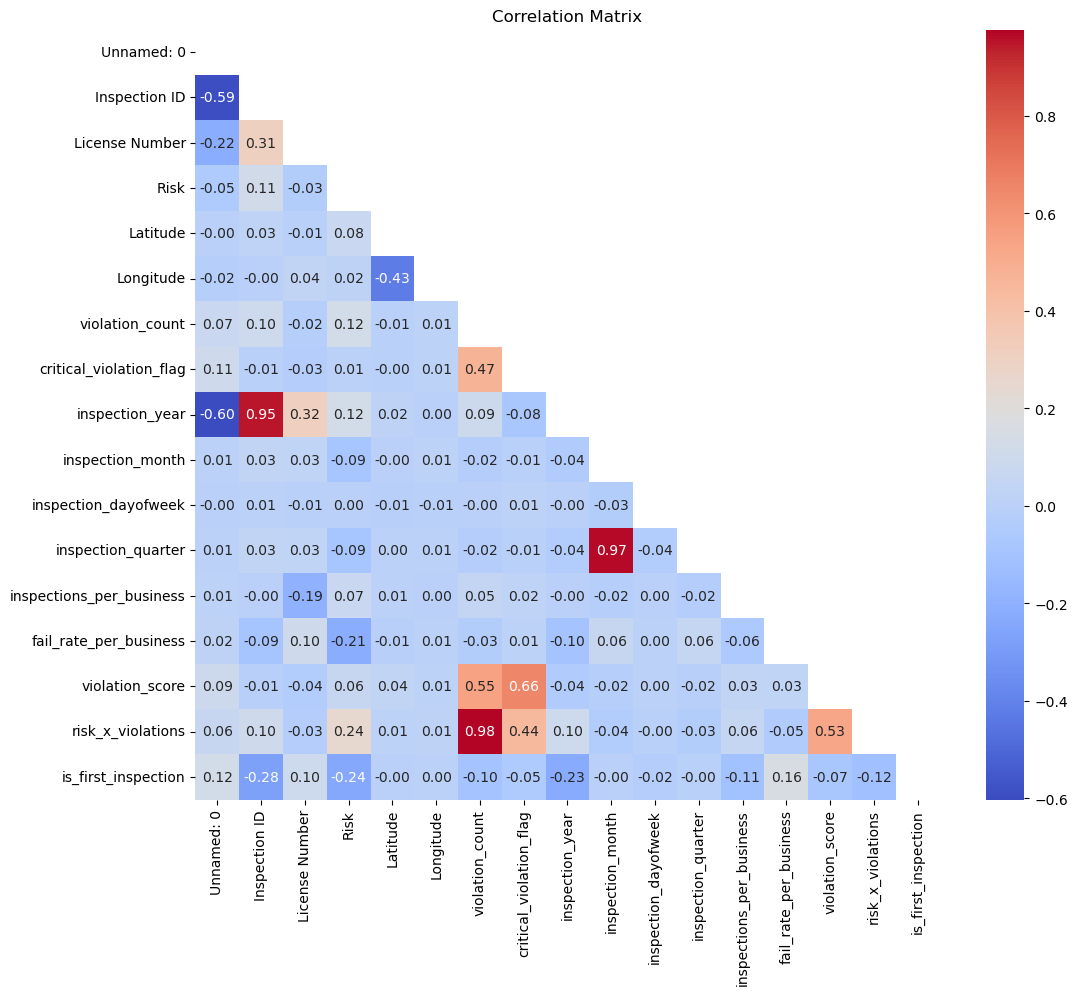

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

#Pass rate by risk category
risk_pass_rate = df.groupby('Risk')['IsPass'].mean().sort_values()

sns.barplot(x=risk_pass_rate.index.astype(str), y=risk_pass_rate.values)
plt.title("Pass Rate by Risk Level")
plt.ylabel("Proportion Passed")
plt.xlabel("Risk Category")
plt.ylim(0.5, 1)
plt.show()

df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])
df['inspection_year'] = df['Inspection Date'].dt.year

#Results over time
yearly = df.groupby('inspection_year')['IsPass'].mean()

plt.plot(yearly.index, yearly.values, marker='o')
plt.title("Pass Rate Over Time")
plt.xlabel("Year")
plt.ylabel("Proportion Passed")
plt.grid(True)
plt.show()

#Top 10 cities by failure rate
city_failure_rate = df.groupby('City')['IsPass'].mean().apply(lambda x: 1 - x)
top_cities = city_failure_rate.sort_values(ascending=False).head(10)

sns.barplot(x=top_cities.values, y=top_cities.index)
plt.title("Top 10 Cities by Failure Rate")
plt.xlabel("Failure Rate")
plt.ylabel("City")
plt.show()

#Pass and fail rate by day of the week
df['inspection_dayofweek'] = df['Inspection Date'].dt.dayofweek

dow_pass_rate = df.groupby('inspection_dayofweek')['IsPass'].mean()

sns.lineplot(x=dow_pass_rate.index, y=dow_pass_rate.values, marker='o')
plt.title("Pass Rate by Day of Week")
plt.xlabel("Day of Week ")
plt.ylabel("Pass Rate")
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()

#Number of inspections by month
df['inspection_month'] = df['Inspection Date'].dt.month

sns.countplot(x='inspection_month', data=df)
plt.title("Monthly Inspection Count")
plt.xlabel("Month")
plt.ylabel("Number of Inspections")
plt.show()

#Correlation between numeric features
numeric_features = df.select_dtypes(include=[np.number])
corr = numeric_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(np.ones(corr.shape)))
plt.title("Correlation Matrix")
plt.show()

